<a href="https://colab.research.google.com/github/13023077uhi/13023077_DataAnalytics/blob/main/Assignment2a_2b_submission_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment Part2 & Part3

# Linear regressor using Python (Using Post-covid data)


In the first part of the assignment, the focus was on preparing data for linear regression by selecting variables with moderate linear relationships to NUM_COLLISIONS_norm while avoiding multicollinearity. Key variables included day_reordered (correlation 0.52) and temp (correlation 0.22), reflecting daily and seasonal effects.

Although both pre-COVID and post-COVID datasets have been prepared, this exercise will focus exclusively on the **post-COVID data**.

In this part of the assignment, we will conduct two types of regression analyses: simple linear regression and multiple linear regression, to predict the number of collisions in New York City.

The **simple linear regression** will focus on the relationship between a single independent variable and the target variable, NUM_COLLISIONS. This approach will help establish whether a direct, linear association exists between a selected feature, such as day_reordered and collision counts. It provides a foundation for understanding the predictive power of individual variables.

The **multiple linear regression**, on the other hand, will incorporate two independent variables simultaneously to account for their combined effects on the target variable. By including variables such as day_reordered, temp, this model will assess how these factors interact to influence collision numbers. Care will be taken to exclude collinear variables to avoid distortions in coefficient estimates and ensure model interpretability.


### Load data

To begin the analysis, the necessary Python libraries were imported. pandas was used to create and manipulate data frames, while numpy was included to support efficient numerical calculations.

The dataset was loaded directly into a data frame from a CSV file hosted on GitHub

In [154]:
# needed to create the data frame
import pandas as pd

# needed to help with speedy maths based calculations
import numpy as np

# create data frame from csv file we hosted on our github
df = pd.read_csv('https://raw.githubusercontent.com/13023077uhi/13023077_DataAnalytics/refs/heads/main/assignment2lineardata_postcovid.csv', index_col=0, )


In [155]:
# make sure we have our data by printing it out
df.head(10)


,day_reordered,temp,dewp,prcp,fog,NUM_COLLISIONS,NUM_COLLISIONS_norm
1,3,69.7,62.5,0.00,0,241,0.262570
2,3,70.2,62.0,0.00,0,254,0.335196
3,3,65.6,65.1,0.00,1,264,0.503030
4,3,36.2,33.0,0.39,0,217,0.218182
5,3,41.1,35.0,0.00,0,242,0.369697
6,3,63.2,52.3,0.00,0,311,0.653631
7,3,47.9,35.9,0.00,1,240,0.246094
8,3,65.7,60.1,0.31,0,297,0.468750
9,3,56.6,53.8,0.00,0,286,0.513966
10,3,79.6,75.5,0.00,0,318,0.692737


In [156]:
#df.to_csv('df1.csv', index=False)

In [157]:
# A scale is not required here, but the constant will be useful in the assignment.
SCALE_NUM_TRIPS = 1.0

Import Keras API within TensorFlow, a high-level library for building deep learning models.

keras: Provides tools for building and training models.

layers: Contains predefined building blocks like dense layers, convolutional layers, dropout layers, etc., which can be stacked to create neural networks.

In [158]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.17.1


## Day_reordered and NUM_COLLISIONS_norm

Create a simplified DataFrame containing only the selected inputs (day_reordered) and the output (NUM_COLLISIONS_norm). This is useful for training models as it isolates the relevant features and target variable.

In [159]:
# create a dataframe with the inputs and the output at the end using the imported dataframe.
df_input_day = df[["day_reordered", "NUM_COLLISIONS_norm"]]

In [160]:
# construct a training set for runnign through the model and a test set, we do this by using sample with 0.8 for an 80% training set and 20% for test.
training_set_day = df_input_day.sample(frac=0.8, random_state=0)
test_set_day = df_input_day.drop(training_set_day.index)

In [161]:
# Check the number of rows in the training set
print(f"Number of rows in training set: {training_set_day.shape[0]}")

# Check the number of rows in the test set
print(f"Number of rows in test set: {test_set_day.shape[0]}")


Number of rows in training set: 870
Number of rows in test set: 217


separate the input features from the target variable, ensuring that the model can independently learn from the features to predict the target during training and evaluation.

pop():

Removes the specified column (NUM_COLLISIONS_norm) from the DataFrame.

Returns the removed column as a pandas Series, which is stored in training_labels_day and test_labels_day.

In [162]:
# copy the datasets and remove the final column, i.e. the output column. We do this using pop.
training_features_day = training_set_day.copy()
test_features_day = test_set_day.copy()

training_labels_day = training_features_day.pop('NUM_COLLISIONS_norm') #removes this colum & returns it as a series
test_labels_day = test_features_day.pop('NUM_COLLISIONS_norm') #removes this colum & returns it as a series

In [163]:
# Here I have put in a scale factor and divided by it. In this dataset, I had already normalised and thus it is 1. However, 600000 is what would make sense based on the data here and we can use this later when testing our model..
training_labels_day = training_labels_day/SCALE_NUM_TRIPS
test_labels_day = test_labels_day/SCALE_NUM_TRIPS

In [164]:
training_features_day.head(5)

,day_reordered
708,7
937,1
692,7
304,4
871,2


In [165]:
# Check type of object
print(type(training_features_day))

<class 'pandas.core.frame.DataFrame'>


In [166]:
training_labels_day.head(5)

,NUM_COLLISIONS_norm
708,0.533333
937,0.212121
692,0.406250
304,0.566406
871,0.612121


In [167]:
# Check type of object
print(type(training_labels_day))

<class 'pandas.core.series.Series'>


Normalization layer:

tf.keras.layers.Normalization: A TensorFlow layer used to standardize input data, ensuring it has a mean of 0 and a standard deviation of 1.

input_shape=[1,]: Specifies the shape of the input data (in this case, single-column data like day_reordered).

axis=None: Applies normalization across the entire dataset, computing a global mean and standard deviation.

In [168]:
# boiler plate for this model. You can see that we have used the training_features here for our normalisation layer that we try and fit to the outputs.
normaliser_day = tf.keras.layers.Normalization(input_shape=[1,], axis=None) # tf.keras.layers.Normalization(axis=-1)
normaliser_day.adapt(np.array(training_features_day))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [169]:
# Print the mean calculated by the normalizer
print("Mean:", normaliser_day.mean.numpy())

# Print the variance calculated by the normalizer
print("Variance:", normaliser_day.variance.numpy())

# Standard deviation can be derived as the square root of the variance
print("Standard Deviation:", np.sqrt(normaliser_day.variance.numpy()))


Mean: [[4.0528736]]
Variance: [[4.0546756]]
Standard Deviation: [[2.0136225]]


In [170]:
type(normaliser_day)

keras.src.layers.preprocessing.normalization.Normalization

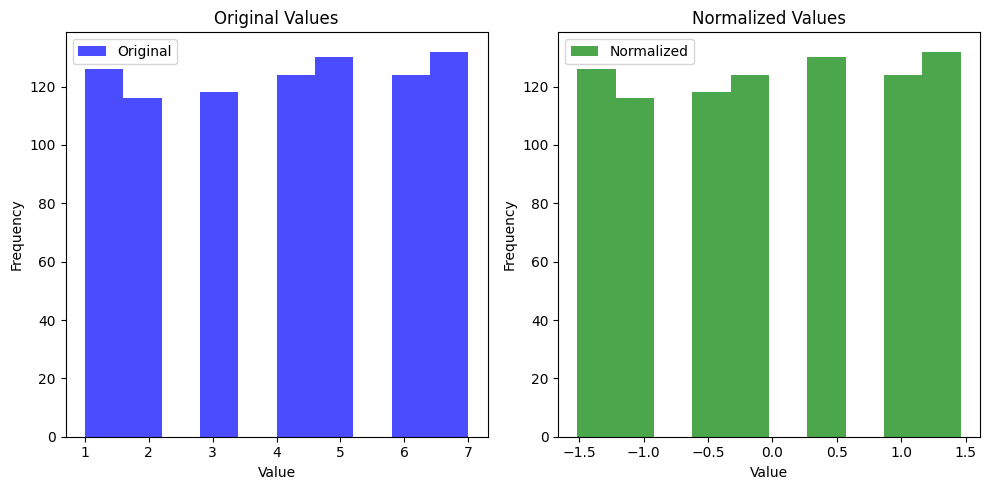

In [171]:
# Visualisation fo normalised input data
import matplotlib.pyplot as plt

# Original and normalized values
original_values = np.array(training_features_day)
normalized_values = normaliser_day(original_values).numpy()

# Plot the original and normalized values
plt.figure(figsize=(10, 5))

# Original values plot
plt.subplot(1, 2, 1)
plt.hist(original_values, bins=10, color='blue', alpha=0.7, label='Original')
plt.title("Original Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()

# Normalized values plot
plt.subplot(1, 2, 2)
plt.hist(normalized_values, bins=10, color='green', alpha=0.7, label='Normalized')
plt.title("Normalized Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()



The purpose of defining model_0 is to create a simple deep learning model tailored for a regression task. This sequential model is structured linearly, where layers are stacked in order from input to output. The first layer is a normalization layer (normaliser_day), which preprocesses the input data by standardizing it, ensuring a mean of 0 and a standard deviation of 1. This preprocessing step helps improve model performance by normalizing the feature range. The second layer is a dense (fully connected) layer with a single neuron (units=1), which serves as the output layer, designed to predict a single scalar value.

In [172]:
# Define a simple deep learning model,
# I have decided to call the model, model_0. We add our normaliser and we are expecting a single output.
model_0 = tf.keras.Sequential([    # Defines a sequential model, where layers are stacked linearly from input to output.
    normaliser_day,                # The normalization layer is added as the first layer to preprocess input data.
    layers.Dense(units=1)          # Adds a dense (fully connected) layer with a single neuron (units=1). This layer is the output layer, designed to produce a single scalar value, which matches the expectation for the regression task (predicting one numerical value)
])

**Model Optimization:**
The optimizer adjusts model parameters (weights and biases) during training to minimize the specified loss function. **Adam Optimizer:** Known for its efficiency and adaptability, Adam works well in most machine learning scenarios, including regression tasks.

**Evaluation of Model Fit:**
Using mean absolute error ensures that the model focuses on reducing the average absolute difference between predictions and actual values, which is suitable for regression problems. **Mean Absolute Error:** A simple, interpretable loss function that provides direct feedback on how well the model predicts numeric values.

**Training Readiness:**
Compiling the model with these settings prepares it for the training phase, where it will iteratively update weights to improve predictions.

In [173]:
model_0.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [174]:
# now we are going to fit the model where we require the training features and labels. We will run it 100 times i.e. epochs and we have applied a further 20% validation split.

%%time
#displays the total time taken to execute the training process. Useful for understanding the computational cost of the model.
history = model_0.fit(    # Trains the model by iteratively updating its weights to minimize the loss function.
    training_features_day,#input features for the training process
    training_labels_day,  #The target values (labels) the model is trying to predict
    epochs=100,           # model will go through the entire training data 100 times to learn the optimal weights
    verbose=0,            # Suppresses detailed output during training to keep the console clean.
    validation_split = 0.2)

# While test data provides a final evaluation of the model, the validation split offers
# real-time feedback during training. This dual approach ensures that the model is
# optimized effectively while maintaining the integrity of the test set for unbiased
# performance assessment.

CPU times: user 9.52 s, sys: 504 ms, total: 10 s
Wall time: 13.7 s


In [175]:
# Now, we will evaluate our model using the test features and labels.
# Tests the trained model on the test dataset (features and labels) to calculate the
# specified loss metric, in this case, the mean absolute error (MAE).
mean_absolute_error_model_0 = model_0.evaluate(
    test_features_day,
    test_labels_day, verbose=0)

In [176]:
# The mean absolute error of the model can be printed out. Remember, we want to minimise this. Perhaps a model with just day and NUM_TRIPS would be better. It will also vary on each training run due to randomisation.
print(mean_absolute_error_model_0)

0.14350223541259766


The mean absolute error (MAE) value of 0.143 indicates that, on average, the predictions made by this model deviate from the true normalized collision values (NUM_COLLISIONS_norm) by approximately 0.143.

MAE of 0.143 corresponds to an average deviation of approximately 143 collisions in the original scale.

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


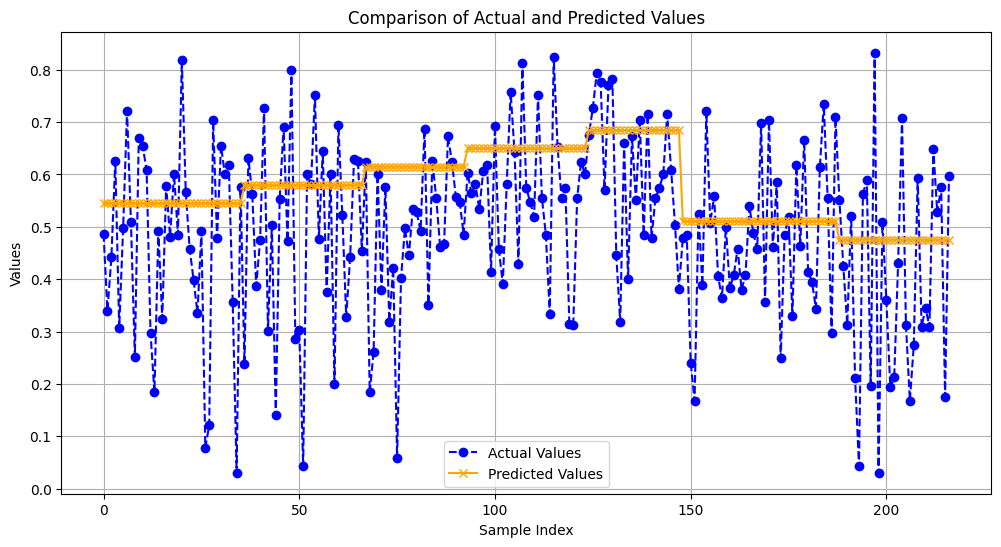

In [177]:
# Comparison of Actual and Predicted Values
import matplotlib.pyplot as plt

# Get predictions from the model
predicted_values = model_0.predict(test_features_day).flatten()  # Flatten to convert to a 1D array
actual_values = test_labels_day.values  # Actual values from the test set

# Line plot to show actual vs predicted values over the dataset
plt.figure(figsize=(12, 6))
plt.plot(actual_values, label="Actual Values", marker='o', linestyle='dashed', color='blue')
plt.plot(predicted_values, label="Predicted Values", marker='x', linestyle='solid', color='orange')
plt.title("Comparison of Actual and Predicted Values")
plt.xlabel("Sample Index")
plt.ylabel("Values")
plt.legend()
plt.grid()
plt.show()


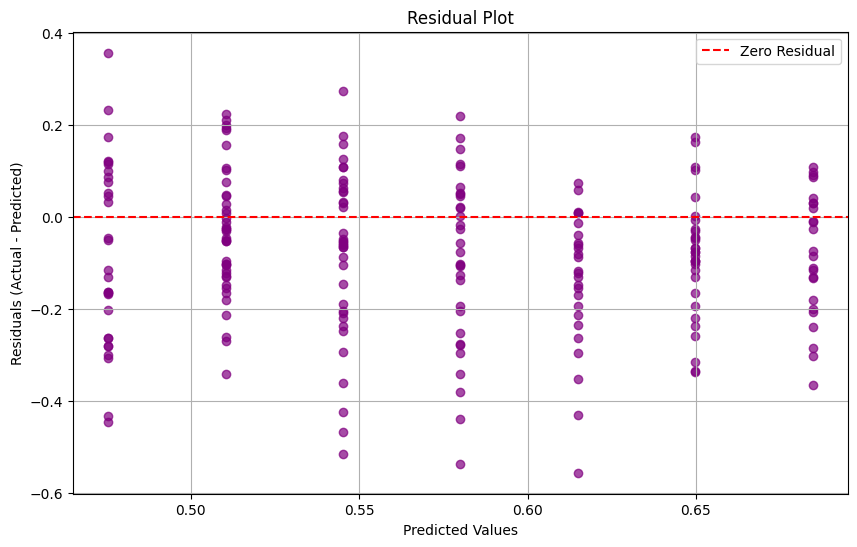

In [178]:
# Calculate residuals
residuals = actual_values - predicted_values

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(predicted_values, residuals, alpha=0.7, color="purple")
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5, label="Zero Residual")
plt.title("Residual Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (Actual - Predicted)")
plt.legend()
plt.grid()
plt.show()


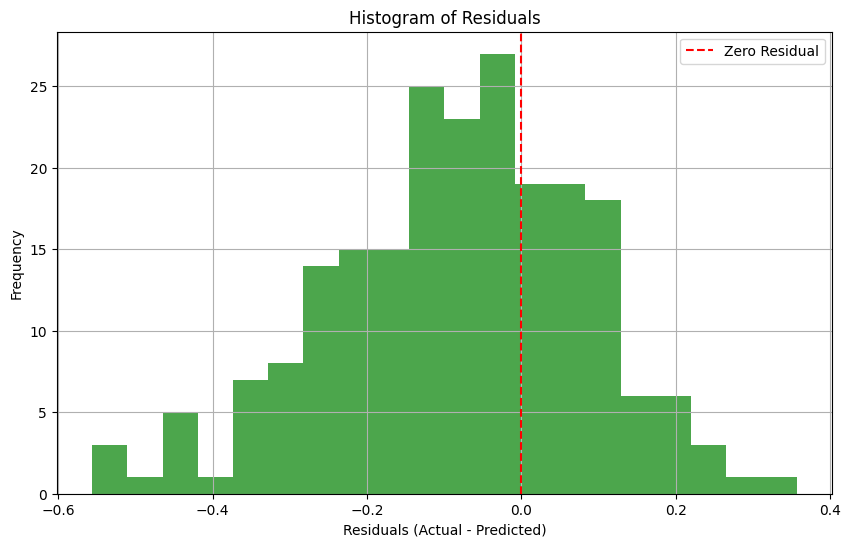

In [179]:
# Histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20, color="green", alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--', linewidth=1.5, label="Zero Residual")
plt.title("Histogram of Residuals")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.legend()
plt.grid()
plt.show()


In [180]:
# Testing
# we create a custom dataframe with 3 values per feature.
input_model_0 = pd.DataFrame.from_dict(data =
				{
            'day' : [1,2,3,4,5,6,7],
        })

In [181]:
input_model_0.head(10)

,day
0,1
1,2
2,3
3,4
4,5
5,6
6,7


Generate predictions from the trained model_0 for the custom input data and scales them up to provide realistic values.

In [182]:
linear_predictions_model_0 = model_0.predict(input_model_0)*1000  #SCALE_NUM_TRIPS # essentially 600000 in this instance would give back realistic numbers based on the TAXI_TRIPS data
print(linear_predictions_model_0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[[475.52338]
 [510.37628]
 [545.2292 ]
 [580.0821 ]
 [614.93506]
 [649.7879 ]
 [684.6408 ]]


The predicted values show an increasing trend from Day 1 (Sunday) to Day 7 (Friday). This suggests that the model has learned a relationship where collision counts gradually rise throughout the week. The predictions range from approximately 475 collisions on Day 1 to around 684 collisions on Day 7.

## Day_reordered , temp and NUM_COLLISIONS_norm


In [183]:
df.head(10)

,day_reordered,temp,dewp,prcp,fog,NUM_COLLISIONS,NUM_COLLISIONS_norm
1,3,69.7,62.5,0.00,0,241,0.262570
2,3,70.2,62.0,0.00,0,254,0.335196
3,3,65.6,65.1,0.00,1,264,0.503030
4,3,36.2,33.0,0.39,0,217,0.218182
5,3,41.1,35.0,0.00,0,242,0.369697
6,3,63.2,52.3,0.00,0,311,0.653631
7,3,47.9,35.9,0.00,1,240,0.246094
8,3,65.7,60.1,0.31,0,297,0.468750
9,3,56.6,53.8,0.00,0,286,0.513966
10,3,79.6,75.5,0.00,0,318,0.692737


In [184]:
# create a dataframe with the inputs and the output at the end using the imported dataframe.
df_input = df[["day_reordered", "temp", "NUM_COLLISIONS_norm"]]

In [185]:
# construct a training set for runnign through the model and a test set, we do this by using sample with 0.8 for an 80% training set and 20% for test.
training_set = df_input.sample(frac=0.8, random_state=0)
test_set = df_input.drop(training_set.index)

In [186]:
# copy the datasets and remove the final column, i.e. the output column. We do this using pop.
training_features = training_set.copy()
test_features = test_set.copy()

training_labels = training_features.pop('NUM_COLLISIONS_norm')
test_labels = test_features.pop('NUM_COLLISIONS_norm')

In [187]:
training_features

,day_reordered,temp
708,7,66.5
937,1,44.1
692,7,31.5
304,4,48.9
871,2,69.5
...,...,...
736,7,32.2
130,3,68.5
350,5,36.3
112,3,33.7


In [188]:
training_labels

,NUM_COLLISIONS_norm
708,0.533333
937,0.212121
692,0.406250
304,0.566406
871,0.612121
...,...
736,0.860606
130,0.387879
350,0.435754
112,0.242188


In [189]:
# Here I have put in a scale factor and divided by it. In this dataset, I had already normalised and thus it is 1. However, 600000 is what would make sense based on the data here and we can use this later when testing our model..
training_labels = training_labels/SCALE_NUM_TRIPS
test_labels = test_labels/SCALE_NUM_TRIPS

In [190]:
# boiler plate for this model. You can see that we have used the training_features here for our normalisation layer that we try and fit to the outputs.
normaliser = tf.keras.layers.Normalization(axis=-1)
normaliser.adapt(np.array(training_features))

In [191]:
# I have decided to call the model, model_1. We add our normaliser and we are expecting a single output.
model_1 = tf.keras.Sequential([
    normaliser,
    layers.Dense(units=1)
])

In [192]:
# more boiler plate for creating a sequential model, we need an optimiser and loss parameter. Here we are going to be using the mean absolute error MAE
model_1.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [193]:
# now we are going to fit the model where we require the training features and labels. We will run it 100 times i.e. epochs and we have applied a further 20% validation split.

%%time
history = model_1.fit(
    training_features,
    training_labels,
    epochs=100,
    verbose=0,
    validation_split = 0.2)

CPU times: user 9.6 s, sys: 419 ms, total: 10 s
Wall time: 13.1 s


In [194]:
# Now, we will evaluate our model using the test features and labels.
mean_absolute_error_model_1 = model_1.evaluate(
    test_features,
    test_labels, verbose=0)

In [195]:
# The mean absolute error of the model can be printed out. Remember, we want to minimise this. Perhaps a model with just day and NUM_TRIPS would be better. It will also vary on each training run due to randomisation.
print(mean_absolute_error_model_1)

0.12454090267419815


The mean absolute error (MAE) value of 0.124 indicates that, on average, the model's predictions deviate from the actual normalized values of NUM_COLLISIONS_norm by approximately 0.124.

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


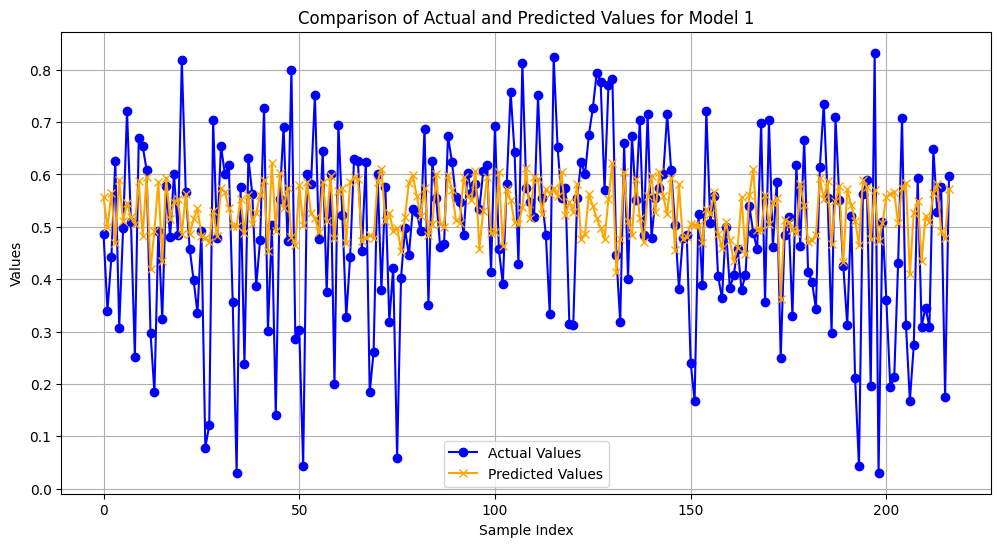

In [196]:
# Comparison of Actual and Predicted Values for Model 1
import matplotlib.pyplot as plt

# Get predictions from model_1
predicted_values_1 = model_1.predict(test_features).flatten()  # Flatten to convert to a 1D array
actual_values_1 = test_labels.values  # Actual values from the test set

# Line plot to show actual vs predicted values over the dataset
plt.figure(figsize=(12, 6))
plt.plot(actual_values_1, label="Actual Values", marker='o', #linestyle='dashed',
         color='blue')
plt.plot(predicted_values_1, label="Predicted Values", marker='x', #linestyle='solid',
         color='orange')
plt.title("Comparison of Actual and Predicted Values for Model 1")
plt.xlabel("Sample Index")
plt.ylabel("Values")
plt.legend()
plt.grid()
plt.show()


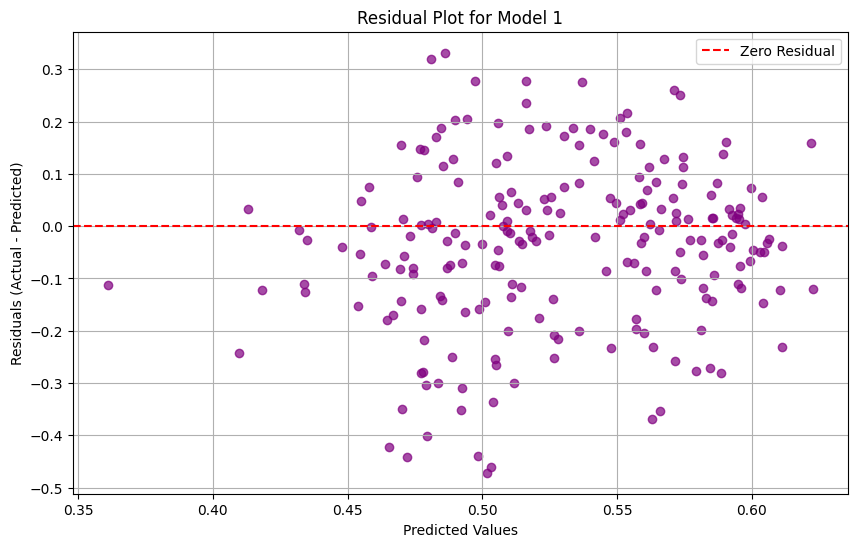

In [197]:
# Calculate residuals
residuals_1 = actual_values_1 - predicted_values_1

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(predicted_values_1, residuals_1, alpha=0.7, color="purple")
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5, label="Zero Residual")
plt.title("Residual Plot for Model 1")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (Actual - Predicted)")
plt.legend()
plt.grid()
plt.show()

In [198]:
# Test
# we create a custom dataframe with 3 values per feature.
input_1 = pd.DataFrame.from_dict(data =
				{
            'day' : [1,1,1], #sunday
            'temp' : [61.8, 31.2, 77.0]
        })

In [199]:
input_1.head()

,day,temp
0,1,61.8
1,1,31.2
2,1,77.0


In [200]:
# next we can check this out, you can multiply by 600000 to get more realistic NUM_TRIPS values.
linear_day_predictions_1 = model_1.predict(input_1[:3])*1000 #SCALE_NUM_TRIPS # essentially 600000 in this instance would give back realistic numbers based on the TAXI_TRIPS data
print(linear_day_predictions_1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[[551.6454 ]
 [445.63467]
 [604.3044 ]]


The model demonstrates a relationship between temperature and the number of collisions. Higher temperatures, such as 77.0°F, are associated with an increase in collisions, with a prediction of approximately 604. Conversely, lower temperatures, like 31.2°F, are linked to fewer collisions, with a prediction of only 445. This trend could reflect seasonal effects, where warmer weather leads to heightened traffic activity, resulting in more collisions. Since all inputs correspond to Day 1 (Sunday), the predictions are predominantly influenced by temperature variations rather than differences between days.

In [201]:
# same as above
input_2 = pd.DataFrame.from_dict(data =
				{
            'day' : [7,7,7],
            'temp' : [61.8, 31.2, 77.0]
        })

In [202]:
linear_day_predictions_2 = model_1.predict(input_2[:3])*SCALE_NUM_TRIPS # essentially 600000 in this instance would give back realistic numbers based on the TAXI_TRIPS data
print(linear_day_predictions_2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[0.5646186 ]
 [0.45860782]
 [0.6172775 ]]


The model predicts the normalized collision counts for Day 7 (Friday) with varying temperatures as follows: 564 for a temperature of 61.8°F, 458 for 31.2°F, and 617 for 77.0°F. These predictions highlight a trend where higher temperatures are associated with increased collision counts, while lower temperatures correspond to fewer collisions. For instance, at 31.2°F, the predicted value of 458 is significantly lower than 617 at 77.0°F, reflecting how warmer weather potentially increases traffic activity, leading to more collisions. The prediction for 61.8°F (564) falls between the other two, consistent with a moderate level of collisions. These results indicate that temperature has a measurable impact on collision frequency for Day 7(Friday), consistent with broader seasonal patterns observed in traffic data.


The predictions indicate that as the day progresses (e.g., from earlier to later days in the week), the number of collisions tends to increase. Additionally, a trend is observed with temperature, where higher temperatures are associated with a higher number of collisions. This suggests that both day and temperature play significant roles in influencing collision frequency, likely reflecting increased traffic activity on certain days and in warmer weather.

Model_0 Vs Model_1

In [203]:
# Evaluate model_0
mae_model_0 = model_0.evaluate(test_features_day, test_labels_day, verbose=0)

# Evaluate model_1
mae_model_1 = model_1.evaluate(test_features, test_labels, verbose=0)

# Print the comparison
print(f"Model 0 MAE: {mae_model_0}")
print(f"Model 1 MAE: {mae_model_1}")


Model 0 MAE: 0.14350223541259766
Model 1 MAE: 0.12454090267419815


Model 1 is slightly better, as it has a lower MAE, indicating that its predictions, on average, deviate less from the actual values compared to Model 0. The improvement in MAE  is small.

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


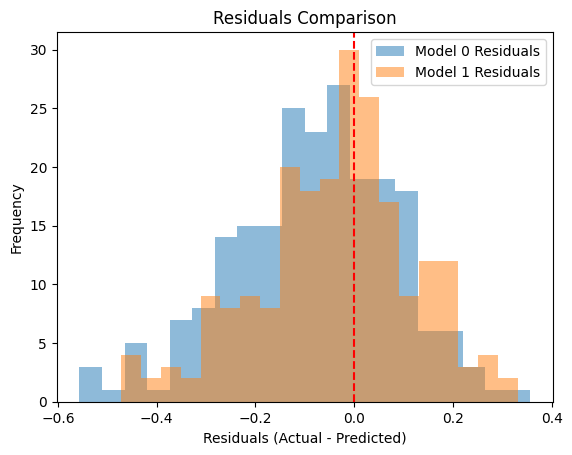

In [204]:
# Residuals for model_0
residuals_0 = test_labels_day.values - model_0.predict(test_features_day).flatten()

# Residuals for model_1
residuals_1 = test_labels.values - model_1.predict(test_features).flatten()

# Plot histograms for residuals
plt.hist(residuals_0, bins=20, alpha=0.5, label='Model 0 Residuals')
plt.hist(residuals_1, bins=20, alpha=0.5, label='Model 1 Residuals')
plt.axvline(0, color='red', linestyle='--', linewidth=1.5)
plt.title("Residuals Comparison")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.legend()
plt.show()


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


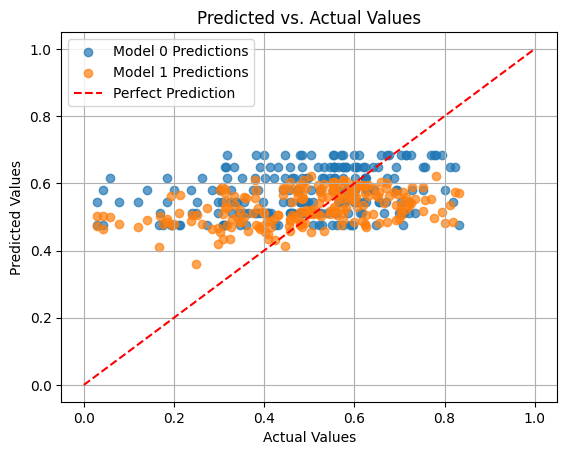

In [205]:
# Predictions for both models
pred_0 = model_0.predict(test_features_day).flatten()
pred_1 = model_1.predict(test_features).flatten()

# Plot predictions vs. actual values
plt.scatter(test_labels_day.values, pred_0, label='Model 0 Predictions', alpha=0.7)
plt.scatter(test_labels.values, pred_1, label='Model 1 Predictions', alpha=0.7)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Perfect Prediction')
plt.title("Predicted vs. Actual Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid()
plt.show()


Model 1 demonstrates marginally better prediction accuracy compared to Model 0, as evidenced by the clustering of orange points closer to the perfect prediction line.This aligns with the lower MAE of Model 1, indicating it performs marginally better overall.

However, both models struggle with predictions particularly for lower and higher actual values, leaving room for improvement. Further feature engineering or model refinement may help reduce the observed variability.

# Deep Neural Network using Python (Using Post-covid data)

For deep neural networks (DNNs), a broader set of variables are utilized, as DNNs excel at modeling non-linear relationships and interactions. Included one-hot encoded categorical variables such as day_reordered (days of the week) and mo (month), which will allow the model to learn distinct patterns for each category without assuming an ordinal relationship. All weather-related variables, including temp, dewp, prcp, and fog, is included, as even weak correlations may provide valuable input to the network. Additionally, normalized variables like NUM_COLLISIONS_norm ensure consistent scaling for efficient training. Unlike linear regression, DNNs are not sensitive to multicollinearity, so collinear features like temp and dewp can both be included, as they might capture complementary patterns.

In [206]:
# create data frame from csv file we hosted on our github
df_dnn = pd.read_csv('https://raw.githubusercontent.com/13023077uhi/13023077_DataAnalytics/refs/heads/main/assignment2dnndata_postcovid.csv', index_col=0)

In [207]:
# make sure we have our data by printing it out
df_dnn.head(10)

,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,...,Thu,Tue,Wed,year,temp,dewp,prcp,fog,NUM_COLLISIONS,NUM_COLLISIONS_norm
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,2022,69.7,62.5,0.00,0,241,0.262570
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2022,70.2,62.0,0.00,0,254,0.335196
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,2023,65.6,65.1,0.00,1,264,0.503030
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,2023,36.2,33.0,0.39,0,217,0.218182
5,0,0,0,0,1,0,0,0,0,0,...,0,0,0,2023,41.1,35.0,0.00,0,242,0.369697
6,0,0,0,0,0,0,1,0,0,0,...,0,0,0,2022,63.2,52.3,0.00,0,311,0.653631
7,0,0,0,0,0,0,0,1,0,0,...,0,0,0,2021,47.9,35.9,0.00,1,240,0.246094
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2021,65.7,60.1,0.31,0,297,0.468750
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2022,56.6,53.8,0.00,0,286,0.513966
10,0,1,0,0,0,0,0,0,0,0,...,0,0,0,2022,79.6,75.5,0.00,0,318,0.692737


In [208]:
# create a dataframe with the inputs and the output at the end using the imported dataframe.
df_dnn_input = df_dnn[["year","temp", "dewp","prcp","fog", "Sun","Sat","Mon","Tue","Wed","Thu","Fri","Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec","NUM_COLLISIONS_norm"]]
df_dnn_input.head()

,year,temp,dewp,prcp,fog,Sun,Sat,Mon,Tue,Wed,...,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,NUM_COLLISIONS_norm
1,2022,69.7,62.5,0.00,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0.262570
2,2022,70.2,62.0,0.00,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0.335196
3,2023,65.6,65.1,0.00,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0.503030
4,2023,36.2,33.0,0.39,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.218182
5,2023,41.1,35.0,0.00,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.369697


In [209]:
# Train and test split
training_dataset_dnn = df_dnn_input.sample(frac=0.8, random_state=0)
test_dataset_dnn = df_dnn_input.drop(training_dataset_dnn.index)

In [210]:
# Check the number of rows in the training set
print(f"Number of rows in training set: {training_dataset_dnn.shape[0]}")

# Check the number of rows in the test set
print(f"Number of rows in test set: {test_dataset_dnn.shape[0]}")

Number of rows in training set: 870
Number of rows in test set: 217


In [211]:
# copy the datasets and remove the final column, i.e. the output column.
training_features_dnn = training_dataset_dnn.copy()
test_features_dnn = test_dataset_dnn.copy()

training_labels_dnn = training_features_dnn.pop('NUM_COLLISIONS_norm')
test_labels_dnn = test_features_dnn.pop('NUM_COLLISIONS_norm')

In [212]:
# A scale is not required here, but the constant will be useful in the assignment.
SCALE_NUM_TRIPS = 1.0

In [213]:
training_labels_dnn = training_labels_dnn/SCALE_NUM_TRIPS
test_labels_dnn = test_labels_dnn/SCALE_NUM_TRIPS

In [214]:
normaliser = tf.keras.layers.Normalization(axis=-1)
normaliser.adapt(np.array(training_features_dnn))

Following compiles a more complex deep neural network (DNN) model, dnn_model_1. Unlike simpler models with a single layer, this DNN incorporates a normalization layer with 22 inputs, followed by two hidden layers, each with 48 neurons and ReLU activation functions. The final output layer has a single neuron, designed to predict a numerical value for regression tasks. The model is compiled with the Adam optimizer (learning rate of 0.001) and mean absolute error (MAE) as the loss function. The 48 neurons in the hidden layers can be adjusted to optimize performance, balancing model complexity and predictive accuracy.

In [215]:
# This is the only difference, instead of a single layer, we have our normalisation layer (22 inputs), 2 layers of 48, with 1 output. The 48 can be adjusted to improve the net.
dnn_model_1 = keras.Sequential([
      normaliser,
      layers.Dense(48, activation='relu'),
      layers.Dense(48, activation='relu'),
      layers.Dense(1)
  ])

dnn_model_1.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

In [216]:
# Fit the model
%%time
history = dnn_model_1.fit(
    training_features_dnn,
    training_labels_dnn,
    validation_split=0.2,
    verbose=0,
    epochs=100)

CPU times: user 11.4 s, sys: 458 ms, total: 11.9 s
Wall time: 14.9 s


In [217]:
# remember, we want to minimise this. The model with the lowest is the best.
dnn_model_1_results = dnn_model_1.evaluate(test_features_dnn, test_labels_dnn, verbose=0)
print(dnn_model_1_results)

0.14627115428447723


In [218]:
# make sure the labels match up with the dataframe from earlier.
input_1 = pd.DataFrame.from_dict(data =
				{
         'year' : [2023, 2023, 2023],
         'temp' : [70.5, 43.9, 40.1],
         'dewp' : [69.3, 39.6, 27.6],
         'prcp' : [0.03, 0, 0],
         'fog' : [1, 0, 0],
         'Sun' : [0,0,0],
         'Sat' : [0,0,0],
         'Mon' : [0,0,0],
         'Tue' : [0,0,0],
         'Wed' : [0,0,0],
         'Thu' : [0,0,0],
         'Fri' : [1,1,1],
         'Jan' : [0,1,0],
         'Feb' : [0,0,0],
         'Mar' : [0,0,0],
         'Apr' : [0,0,0],
         'May' : [0,0,0],
         'Jun' : [0,0,0],
         'Jul' : [0,0,0],
         'Aug' : [1,0,0],
         'Sep' : [0,0,0],
         'Oct' : [0,0,0],
         'Nov' : [0,0,0],
         'Dec' : [0,0,1],
        })


In [219]:
linear_day_predictions = dnn_model_1.predict(input_1[:3])*1000 #SCALE_NUM_TRIPS
linear_day_predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


array([[563.6685 ],
       [248.90155],
       [394.3362 ]], dtype=float32)

The model predicts collision counts based on weather and temporal factors, showing that higher temperatures, such as 70.5°F in August with fog and light precipitation, result in the highest prediction of 563 collisions. Conversely, lower temperatures in winter months, like 43.9°F in January and 40.1°F in December, lead to fewer collisions, with predictions of 248 and 394, respectively.  These results align with seasonal traffic patterns, where summer months with warmer weather and higher activity see more collisions, while winter months experience fewer incidents.

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


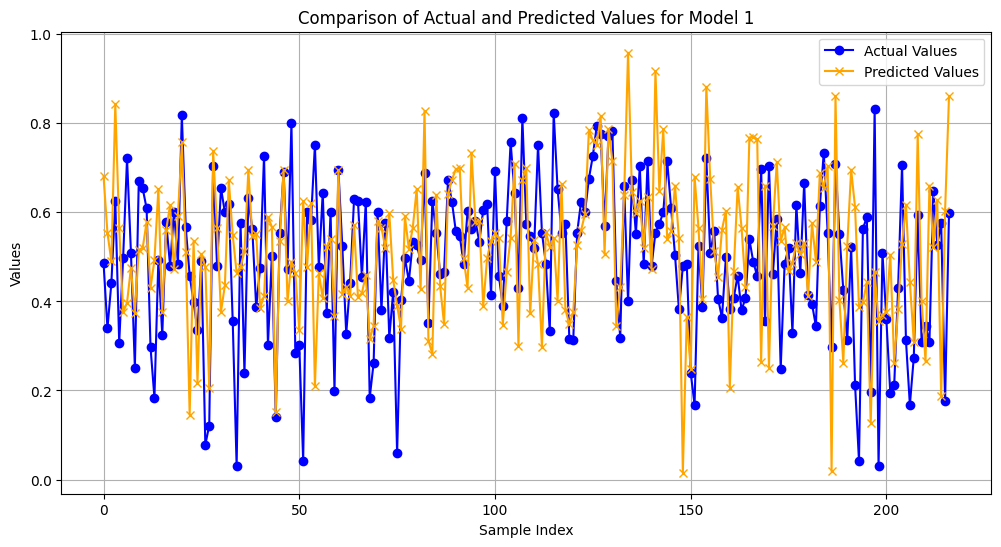

In [220]:
# Comparison of Actual and Predicted Values for Model 1
import matplotlib.pyplot as plt

# Get predictions from model_1
predicted_values_dnn = dnn_model_1.predict(test_features_dnn).flatten()  # Flatten to convert to a 1D array
actual_values_dnn = test_labels_dnn.values  # Actual values from the test set

# Line plot to show actual vs predicted values over the dataset
plt.figure(figsize=(12, 6))
plt.plot(actual_values_dnn, label="Actual Values", marker='o', #linestyle='dashed',
         color='blue')
plt.plot(predicted_values_dnn, label="Predicted Values", marker='x', #linestyle='solid',
         color='orange')
plt.title("Comparison of Actual and Predicted Values for Model 1")
plt.xlabel("Sample Index")
plt.ylabel("Values")
plt.legend()
plt.grid()
plt.show()

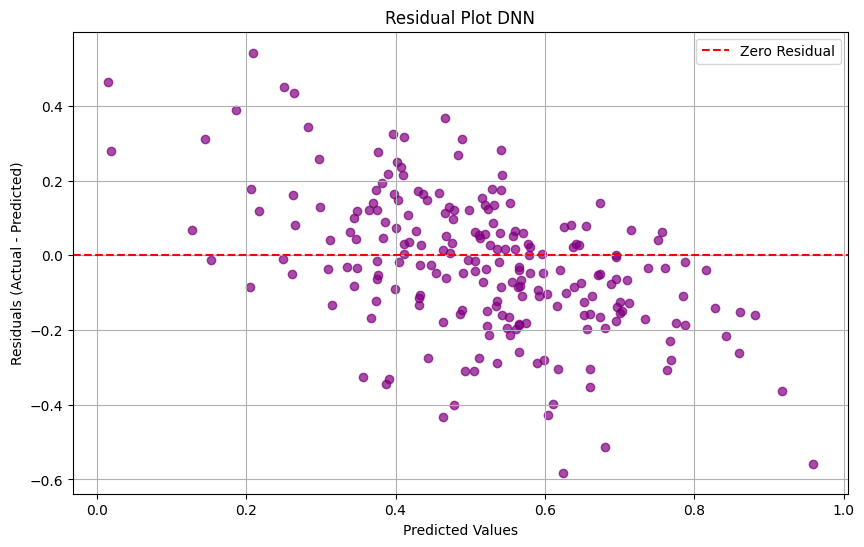

In [221]:
# Calculate residuals
residuals_dnn = actual_values_dnn - predicted_values_dnn

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(predicted_values_dnn, residuals_dnn, alpha=0.7, color="purple")
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5, label="Zero Residual")
plt.title("Residual Plot DNN")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (Actual - Predicted)")
plt.legend()
plt.grid()
plt.show()

In [222]:
# Evaluate model_0
mae_model_0 = model_0.evaluate(test_features_day, test_labels_day, verbose=0)

# Evaluate model_1
mae_model_1 = model_1.evaluate(test_features, test_labels, verbose=0)

# Evaluate model_dnn
mae_model_dnn = dnn_model_1.evaluate(test_features_dnn, test_labels_dnn, verbose=0)

# Print the comparison
print(f"Model 0 MAE: {mae_model_0}")
print(f"Model 1 MAE: {mae_model_1}")
print(f"Model DNN MAE: {mae_model_dnn}")

Model 0 MAE: 0.14350223541259766
Model 1 MAE: 0.12454090267419815
Model DNN MAE: 0.14627115428447723


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


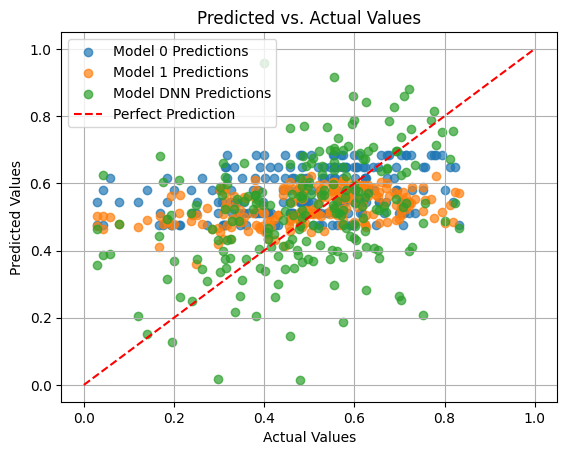

In [223]:
# Comparing Predictions for all 3 models
pred_0 = model_0.predict(test_features_day).flatten()
pred_1 = model_1.predict(test_features).flatten()
pred_dnn = dnn_model_1.predict(test_features_dnn).flatten()

# Plot predictions vs. actual values
plt.scatter(test_labels_day.values, pred_0, label='Model 0 Predictions', alpha=0.7)
plt.scatter(test_labels.values, pred_1, label='Model 1 Predictions', alpha=0.7)
plt.scatter(test_labels_dnn.values, pred_dnn, label='Model DNN Predictions', alpha=0.7)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Perfect Prediction')
plt.title("Predicted vs. Actual Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid()
plt.show()

This scatter plot compares the predicted values from Model 0, Model 1, and a Deep Neural Network (DNN) model against actual values, with a red dashed line indicating perfect predictions. While all models demonstrate a general alignment with the perfect prediction line, there are notable differences in their performances. Model DNN Predictions (green points) exhibit a wider spread, indicating variability in accuracy, particularly for lower actual values. Model 1 Predictions (orange points) tend to cluster closer to the perfect prediction line, showing relatively consistent predictions and a better overall fit compared to Model 0 (blue points). Model 0 Predictions appear to perform slightly less effectively, with more deviation from the perfect line. The distribution suggests that while the DNN model may capture complex relationships, it struggles with consistency, whereas Model 1 offers a balance of simplicity and accuracy, performing slightly better than Model 0.